In [437]:
import numpy as np
import matplotlib.pyplot as plt
N=128 # number of time steps
A0 = np.load('As.npy')
A0fix = np.load('Asfix.npy')
noise0 = np.load('Ns.npy')/np.sqrt(16) # 16 samples notch integration
karin = np.load('kar.npy')
M = len(karin)
kar =np.outer(np.arange(N), karin)
fbase = 50e3
dt = 4096*16/102.4e6
alpha2phi = 2*np.pi*dt*fbase/1e6


In [448]:
def generate_data (sig = 1e-3, A=0.1*np.ones(M), noise =1 *np.ones(M)):
    phi_ofs = np.random.uniform(0,2*np.pi,M)
    n = (np.random.normal (0, 1/np.sqrt(2),(N,M))+1j*np.random.normal(0,1/np.sqrt(2),(N,M)) ) *noise[None,:]
    s = A*np.exp(1j*(phi_ofs[None,:]+kar*sig))
    return s+n

def estimate_phi (data,A = None, noise = None, fds=False):
    sum0 = np.sum(data,axis=0)
    sum0x = (np.abs((data[::2]-data[1::2])**2).sum(axis=0))
    SNR2 = np.abs(sum0**2)/sum0x
    sum1 = (data*kar*1j).sum(axis=0)
    sum2 = (-data*kar**2).sum(axis=0)
    
    FD = np.real(sum0*np.conj(sum1))
    SD = np.real(sum2*np.conj(sum0)+sum1*np.conj(sum1))
    if (fds):
        return FD, SD, SNR2

    weights = A**2/noise**4
    return (FD*weights).sum()/(SD*weights).sum(), SNR2.sum()
    

def get_error (sig, A, noise, Ngo=100000):
    res, snr2 = np.array([estimate_phi(generate_data(sig, A,noise),A,noise) for i in range(Ngo)]).T
    mean = res.mean()
    std = res.std()
    snrmean = snr2.mean()
    snrstd = snr2.std()
    return mean, std, snrmean, snrstd

def SNR(A, noise):
    SNR2 = (A**2/noise**2).sum()*N
    return np.sqrt(SNR2)

def SNRreport(A, noise, N3=256):
    t_one = N*16*4096/102.4e6
    t_intg = t_one*N3
    print ("SNR one: ", SNR(A, noise))    
    print ("t_one",t_one)
    print ("t_intg",t_intg)
    SNR_intg = (A/noise)*np.sqrt(N*N3)
    print ("SNR intg min: ", SNR_intg[SNR_intg>0].min())
    print ("SNR intg max: ", SNR_intg.max())
    plt.plot(karin*fbase/1e6,SNR_intg)
    plt.xlabel('frequency [MHz]')
    plt.ylabel('SNR')
    plt.loglog()
    

SNR one:  11.232104071949895
t_one 0.08192
t_intg 20.97152
SNR intg min:  1.4353971249202266
SNR intg max:  22.13050520042888


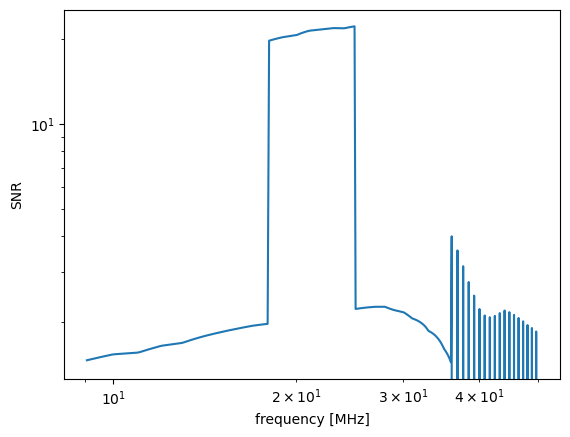

In [449]:
SNRreport(A0fix, noise0)

In [430]:
def var_phi(sig, A, noise, Ngo):
    fdsd = np.array([estimate_phi(generate_data(sig, A,noise),fds=True) for i in range(Ngo)])
    fd = fdsd[:,0]
    sd = fdsd[:,1]
    snr2 = fdsd[:,2]
    #plt.plot(sd.sum(axis=1),fd.sum(axis=1),'b.')
    res = fd.sum(axis=1)/sd.sum(axis=1)
    opt_we = (A**2)/(0.5*noise**2*(noise**2+A**2*N))
    #print(snr2.-1.0320*M)
    snr = snr2.sum(axis=1)
    print (opt_we.min(), opt_we.max())
    res_opt = (fd*opt_we[None,:]).sum(axis=1)/(sd*opt_we[None,:]).sum(axis=1)

    #fd_mean_pred = -A**2*sig*((kar**2).sum()*N-np.outer(kar,kar).sum())
    #sd_mean_pred = np.array([-A[k]**2*((kar[:,k]**2).sum()*N-np.outer(kar[:,k],kar[:,k]).sum()) for k in range(M)])
    #print (sd.mean()/sd_mean_pred)
    #sigma=1
    #fdvarprednn = sigma**4*0.5*(N*(kar**2).sum()-np.outer(kar,kar).sum())
    #fdvarprednC = 0.5*np.abs(A**2)*sigma**2*(kar**2).sum()*N**2
    #fdvarpredCn = 0.5*np.abs(A**2)*sigma**2*(np.outer(kar,kar)).sum()*N
    #fd_var_pred = fdvarprednn+fdvarprednC-fdvarpredCn
    #K1 = N*(kar**2).sum()
    #K2 = np.outer(kar,kar).sum()
    #invar = A**2/(0.5*noise**2*(noise**2+A**2*N))*np.abs(sd_mean_pred)
    #err2_pred1 = 1/invar
    #print (invar)
    #resi = (fd/sd).mean(axis=0)
    #resiv = (fd/sd).var(axis=0)
    #invar = 1/resiv# A**2/noise**4
    #res_opt2 = (fd/sd*invar[None,:]).sum(axis=1)/invar.sum()
    #print (resiv)
    #print(1/invar)


    #err2_pred = fd_var_pred/sd_mean_pred**2
    #print (err2_pred, err2_pred1)
    #print (fd.var(), sd.var())
    #print (fd_var_pred, fd.var()/fd_var_pred,'<<')
    #print (res.mean(), res.var(), fd.var()/sd.mean()**2, fd_var_pred/sd_mean_pred**2, res.var()/err2_pred)
    #plt.plot(res)
    plt.plot(res_opt)
    print(res_opt.min(), res_opt.max())
    #plt.hist(res_opt)
    return res.mean(), res.var(), res_opt.mean(), res_opt.var(), snr.mean(axis=0), snr.std(axis=0)#fd.var()/sd.mean()**2, fd_var_pred/sd_mean_pred**2, res.var()/err2_pred


SNR: 11.238410172560972
1058973608.8462695 334232632421.3271
-2.1009020178852064e-05 1.633187572035273e-05


(-0.0002345669729942751,
 5.9532748447051573e-05,
 -2.2286741276242539e-07,
 2.6845269879597735e-11,
 545.1556161494626,
 26.68904284970856)

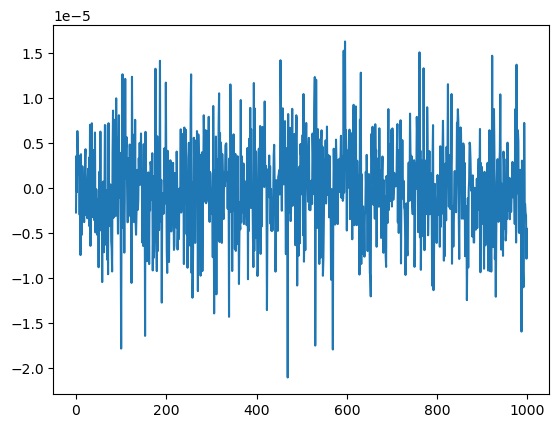

In [409]:
A=A0fix
sig=0
noise = noise0
print ('SNR:', SNR(A, noise))

var_phi(sig, A, noise,1000)
#lt.errorbar(x=np.arange(M),y=x[4],yerr=0*np.sqrt(x[5]))

In [370]:
A=A0fix*10
noise = noise0
L = 1/kar.max()*7
sigl = np.linspace(-L,L,100)
print (SNR(A, noise))

s,e,_,_ = np.array([get_error(sig, A, noise,100) for sig in sigl]).T

112.38410172560971


(-5.517328351974021e-05, 5.517328351974021e-05)

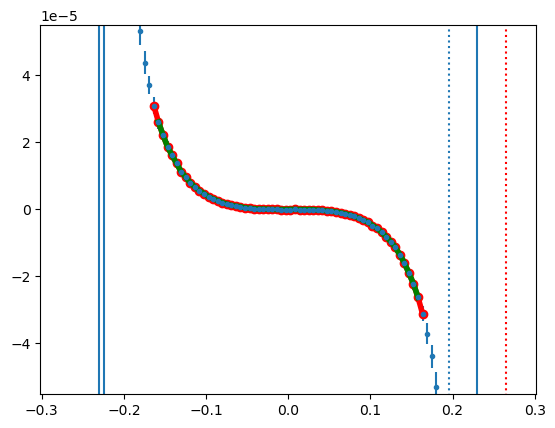

In [371]:
w = np.where(np.abs(sigl-s)<np.abs(sigl))
w2 = np.where(np.abs(sigl-s)+2*np.abs(e)<np.abs(sigl))
plt.errorbar(sigl/alpha2phi,sigl-s,yerr=e,fmt='.')
plt.plot(sigl[w]/alpha2phi,sigl[w]-s[w],'ro-',lw=4)
plt.plot(sigl[w2]/alpha2phi,sigl[w2]-s[w2],'g-',lw=4)
plt.axvline(5/kar.max()/alpha2phi,-1,1,ls=':')
plt.axvline(2/kar.mean()/alpha2phi,-1,1,ls=':',color='r')
plt.ylim(-L,L)

In [372]:
A=A0fix
noise = noise0
L = 1/kar.max()*7
sigl = np.linspace(-L,L,100)
print (SNR(A, noise))
slar = np.logspace(-1.5,0.2,40)
SNRx = [SNR(A*sl, noise) for sl in slar]
s,e,snr,snrer = np.array([get_error(0, A*sl, noise,1000) for sl in slar]).T

11.238410172560972


7.217672735667937 469.3949201608982 421.59614031654115 417.55154164781686


459.5310501358231

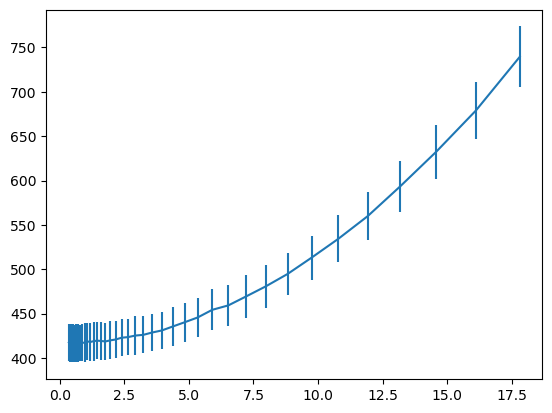

In [373]:
plt.errorbar(SNRx,snr,yerr=snrer)
print (SNRx[30],snr[30],snr[30]-2*snrer[30],snr[0])
snr[0]+2*snrer[0]

[]

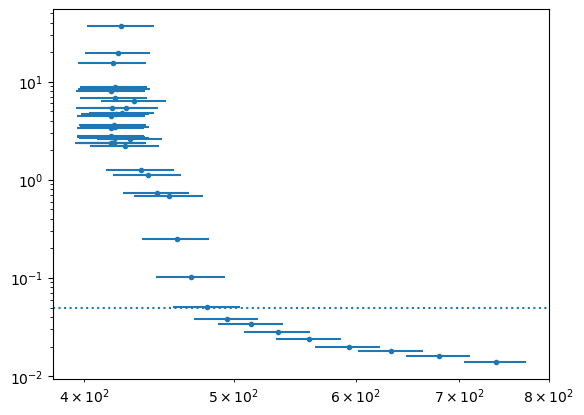

In [374]:
plt.errorbar(snr,e/alpha2phi,xerr=snrer,fmt='.')

plt.axhline(0.05,0,1,ls=':')
plt.loglog()

[]

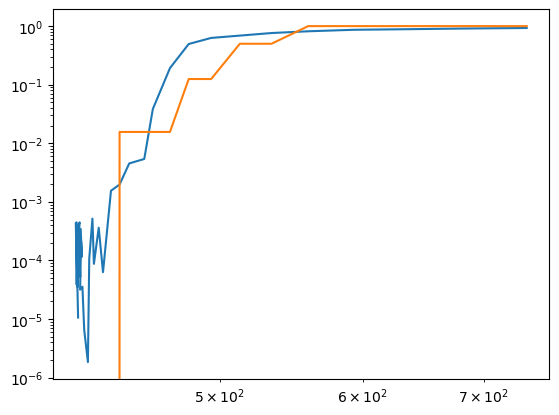

In [375]:
y=np.ones_like(snr)
y[snr<550]=1/2
y[snr<500]=1/2**3
y[snr<470]=1/2**6
y[snr<440]=0.000

plt.plot(snr,1/(1+(e/alpha2phi)**2/0.05**2))
plt.plot(snr,y)
plt.loglog()


In [376]:
def x():
    n = (np.random.normal (0, 1/np.sqrt(2),N)+1j*np.random.normal(0,1/np.sqrt(2),N) )
    top = np.abs(n.sum()**2)
    bot = np.abs(((n[::2]-n[1::2])**2)).sum()
    return top,bot

In [142]:
t,b=np.array([x() for a in range(10000000)]).T
t.mean(), b.mean(), (t/b).mean()

(128.05349357936404, 128.00167966710674, 1.016317086180843)

In [214]:
alpha2phi

0.0002010619298297468